In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
# read in the data
chemistry_samples = pd.read_csv('chemistry_samples.csv')
chemistry_test = pd.read_csv('chemistry_test.csv')

# Linear Regression

We import the data and set the column LC50 as the response variable $y$ and the rest of the columns are our predictor variables. We also standardise our data. While standardisation will not have effect on the optimal coefficients of the linear regression (except for the intercept coefficient which will now be close to zero), it will have effect on the ridge and lasso regressions.

Note that we standardise the test data using the mean and standard deviation from the samples datasets, since the sample datasets are larger and the mean and std should be more accurate (this may not be the case if the test data is taken from different regions, but we assume that it is a random sample from the whole data).

In [4]:
# Samples data
y_chemistry_samples = chemistry_samples['LC50']  # response variable 
# standardize
y_chemistry_samples_std = (y_chemistry_samples - np.mean(y_chemistry_samples, 0)) / np.std(y_chemistry_samples, 0)
x_chemistry_samples = chemistry_samples.loc[:,chemistry_samples.columns != 'LC50']  # predictor variables
# standardize
x_chemistry_samples_std = (x_chemistry_samples - np.mean(x_chemistry_samples, 0)) / np.std(x_chemistry_samples, 0)
# add ones as the first column corresponding to beta_0
X_chemistry_samples_std = np.hstack([np.ones((x_chemistry_samples_std.shape[0],1)), x_chemistry_samples_std])

# Test data
y_chemistry_test = chemistry_test['LC50']  # true outcomes for the test data
# standardize using mean and std from sample data
y_chemistry_test_std = (y_chemistry_test - np.mean(y_chemistry_samples, 0)) / np.std(y_chemistry_samples, 0)
x_chemistry_test = chemistry_test.loc[:,chemistry_test.columns != 'LC50']  # features from testing data
# standardize using mean and std from sample data
x_chemistry_test_std = (x_chemistry_test - np.mean(x_chemistry_samples, 0)) / np.std(x_chemistry_samples, 0)
# add ones as the first column corresponding to beta_0
X_chemistry_test_std = np.hstack([np.ones((x_chemistry_test_std.shape[0],1)), x_chemistry_test_std])

We will fit the data according to the linear model
\begin{equation}
y = \beta_0 + \beta_1  x_1 + \cdots + \beta_{10}  x_{10} +  \varepsilon,
\end{equation}
where $ y$ is the toxicity factor LC50, $x_i$ are the ten features and $\varepsilon$ are the errors. From the lectures we know that we have
\begin{equation}
\hat{ \beta} = (X^TX)^{-1}X^T y.
\end{equation}

In [5]:
def linear_regression(X, y):
    """
    Input:
    X: matrix of predictor variables
    y: vector of outcomes
    Output:
    Returns vector with the coefficients fitted from the linear model.
    """

    betas = np.linalg.solve(X.T @ X, X.T @ y)
    return betas

We now fit our model and print the optimal coefficients for our data.

In [6]:
# Compute and print betas
betas_linear = linear_regression(X_chemistry_samples_std, y_chemistry_samples_std)
print("Model coefficients: ", betas_linear)

Model coefficients:  [ 7.45303276e-16  2.90108245e-02  4.45606153e-01 -1.25021223e-02
  2.09811164e-01  3.63698550e-03  4.68524940e-01 -2.18878786e-01
 -2.10439111e-01 -6.62731202e-02 -6.87146683e-04]


Now we create a function that computes the $R^2$ coefficient. It is calculated as such:
\begin{equation}
R^2 = 1 - \frac{RSS}{\sum_{i=1}^n (Y - \overline{Y})^2},
\end{equation}
where $RSS = \sum_{i=1}^n (Y - \hat{Y})^2$, ($\hat{Y}$ are the predicted outcomes), $n$ is the number of obsevations.

In [7]:
def r_squared(X, y_true, betas):
    """
    Input:
    y: vector of true outcomes
    X: matrix of observations
    betas: coefficients
    Output:
    Returns the R squared for the given inputs.
    """

    # Calculate predicted outcomes
    y_prediction = X @ betas

    # Compute RSS and TSS
    RSS = np.dot(y_true - y_prediction, y_true - y_prediction)
    TSS = np.dot(y_true - np.mean(y_true), y_true - np.mean(y_true))

    # Return the R squared
    return 1 - RSS/TSS

We now calculate the $R^2$ on our sample data.

In [8]:
# Calculate the R squared for the sample data
in_sample_R_squared_linear = r_squared(X_chemistry_samples_std, y_chemistry_samples_std, betas_linear)
print("In-sample R^2 =", in_sample_R_squared_linear)

In-sample R^2 = 0.8718259975718016


We can see that the adjusted $R^2$ is very high (close to $1$). This can be interpreted as approximately $87\%$ of the total variance of the data is explained by the model.

Now that we have obtain the $\beta$ coefficients from our model, we can predict the target variable for the test data and calculate the out of sample $R^2$. Note that the prediction for the target variable is computed inside the r_squared function.

In [9]:
# Compute the out of sample R^2
out_sample_R_squared_linear = r_squared(X_chemistry_test_std, y_chemistry_test_std, betas_linear)
print("Out-of-sample R^2 =", out_sample_R_squared_linear)

Out-of-sample R^2 = 0.8642933369927281


We can see that the out-of-sample $R^2$ is a bit smaller than the in-sample one which is understandable since the betas were calculated for the sample data. Nevertheless, both $R^2$ are very close to each other which means that approximately the same amount of variance of the data is explained by the model. We note that while the $R^2$ coefficient on its own is not a guarantee for a good fit of the model, we observe that there is almost no change in the $R^2$ between the sample and test data which indicates that the model is well generalized and did not overfit.

We also compute the MSE of our predictions. We will use this to compare the different regressions.

In [10]:
# Compute predictions
y_prediction_linear = X_chemistry_test_std @ betas_linear

# Compute the MSE
linear_mse = np.mean((y_prediction_linear - y_chemistry_test_std)**2)
print("The MSE of our linear regression estimates is: ", linear_mse)

The MSE of our linear regression estimates is:  0.12876794450042037


## Ridge Regression

Here we work with the chemistry samples data. We divide the data into $5$ parts and perform $5$ iterations in each of which one of the parts is the validations set and the rest is the training set. We perform a ridge regression (with parameter lambd) on the training set and obtain the solution:
\begin{equation}
\hat{\beta}_{ridge} = (X^TX + \lambda I)^{-1}X^Ty,
\end{equation}
where $X$ and $y$ are from the training set. Now we predict the $y_{val}$ of the validation set as follows:
\begin{equation}
\hat{y}_{val} = X_{val} \hat{\beta}_{ridge},
\end{equation}
where $X_{val}$ are the preidctors of the validation set. Now that we have our predicted $y^*_{val}$ and the true $y_{val}$, we can calculate the MSE for each of the 5 iterations as 
\begin{equation}
MSE_i = \frac{1}{n_i}\sum_{j=1}^{n_i}(Y_j - \hat{Y}_j)^2 = \frac{1}{n_i}(Y_{val} - \hat{Y}_{val} )^T(Y_{val}-\hat{Y} _{val}),
\end{equation}
where $n_i$ is the number of elements in the validation set at iteration $i$, $Y_{val}$ is the vector with true values from the validation set and $Y^*_{val}$ is its prediction from above. After computing each of the MSE, we take their average. Now we have obtained a function that evaluates our regression for a given $\lambda$. We then plug in different values for $\lambda$ to find the optimal one.

In [11]:
def ridge_regression(X, y, lambd):
    """
    Input:
    X: matrix of predictor variables
    y: vector of response variables
    lambd: parameter of the Ridge regression
    Output:
    Returns the coefficients beta which minimise the loss function for the ridge regression.
    """
    
    # Remove intercept from regularisation term
    I = np.identity(X.shape[1])
    I[0,0] = 0

    # Compute the betas for the ridge regression
    beta_ridge = np.linalg.solve(X.T @ X + lambd * I, X.T @ y)
    return beta_ridge

In [12]:
def cross_validation_ridge(X, y, lambd, folds):
    """
    Input:
    X: matrix of predictor variables
    y: vector of response variables
    lambd: parameter of the Ridge regression
    T: number of folds
    Outcome:
    Return the average MSE over the T validation sets.
    """
    
    # Initialize a list with MSEs
    MSEs = []

    for i in range(len(folds)):

        # Set training and validation indices
        validation_indices = folds[i]
        training_indices = list(set(range(y.shape[0])) - set(validation_indices))

        # Separate into training and validation datasets
        X_train_i = X[training_indices, :]
        y_train_i = y[training_indices]
        X_val_i = X[validation_indices, :]
        y_val_i = y[validation_indices]

        # Compute the betas for a ridge regression
        beta = ridge_regression(X_train_i, y_train_i, lambd)
        
        # Compute predictions for y
        y_prediction_i = X_val_i @ beta
        
        # Compute the MSE
        MSE_i = np.mean((y_val_i - y_prediction_i)**2)
        MSEs.append(MSE_i)
    
    # Return the average MSE
    return np.mean(MSEs)

Now we create a function that loops over a range of values for the $\lambda$ parameter of the ridge regression and returns the optimal $\lambda$.

In [13]:
def choose_best_lambd_ridge(X, y, lambd_range, folds):
    """
    Input:
    X: matrix of predictor variables
    y: vector of response variables
    lambda_range: array with lambda values
    Output:
    Returns the lambda for which the CV MSE is lowest and the value of that MSE.
    """
    
    # Create a list containing the MSE for each value of lambd
    lambda_MSEs = np.zeros((len(lambd_range),))
    for i, lambd in enumerate(lambd_range):
        lambda_MSEs[i] = (cross_validation_ridge(X, y, lambd, folds))

    # Find the minimal MSE and its index
    min_mse = np.min(lambda_MSEs)   
    min_mse_index = np.argmin(lambda_MSEs)

    # Return the minimal MSE and the lambd corresponding to the min MSE
    return min_mse, lambd_range[min_mse_index]

Now we find the optimal $\lambda$ for our data and print it together with the MSE for that $\lambda$. We first create a plot showing the MSE for different values of $\lambda$. We can see that the curve is convex and we want the optimal $\lambda$ which minimises it.

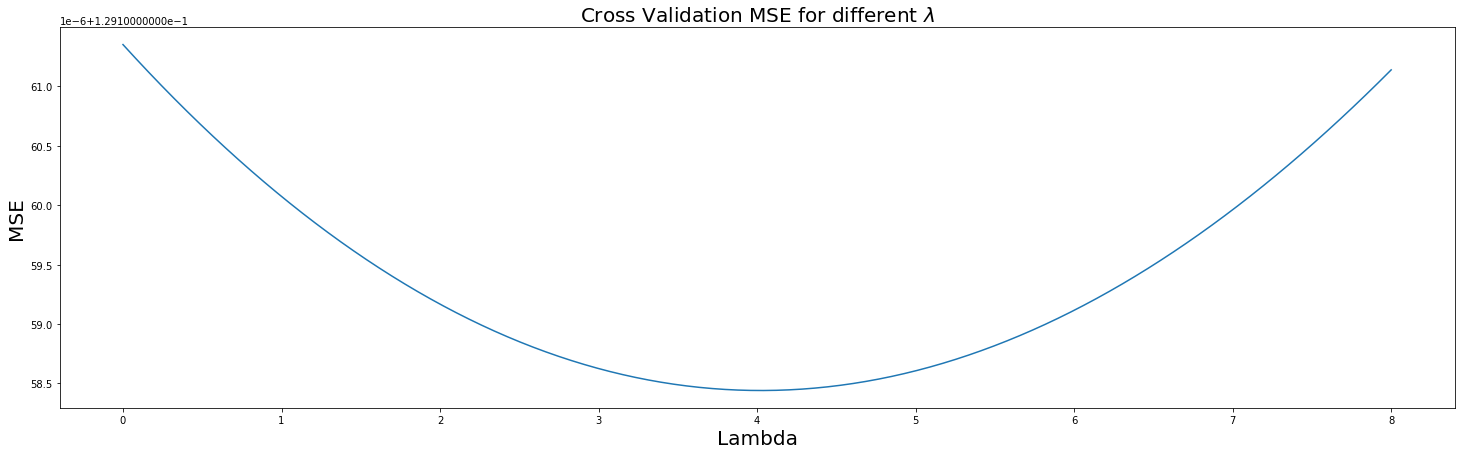

In [14]:
# Create folds
folds = np.array_split(np.arange(np.shape(X_chemistry_samples_std)[0]), 5)

# Set a range for lambda
lambd_range= np.linspace(0, 8, 100)

# Compute MSEs for these lambdas
mse_list = [cross_validation_ridge(X_chemistry_samples_std,
                                   y_chemistry_samples_std,
                                   lambd, folds) for lambd in lambd_range]

# Plot
plt.figure(figsize=(25,7))
plt.plot(lambd_range, mse_list)
plt.xlabel("Lambda", size=20)
plt.ylabel("MSE", size=20)
plt.title("Cross Validation MSE for different $\lambda$", size=20)
plt.show()

We now search for the optimal value of $\lambda$ and print it together with its corresponding MSE.

In [15]:
# Compute optimal lambda and the MSE corresponding to it
min_MSE_ridge, optimal_lambda_ridge = choose_best_lambd_ridge(X_chemistry_samples_std,
                                                              y_chemistry_samples_std,
                                                              lambd_range=lambd_range,
                                                              folds=folds)
# Print results
print("Optimal lambda = ", optimal_lambda_ridge)
print("Minimal MSE = ", min_MSE_ridge)

Optimal lambda =  4.040404040404041
Minimal MSE =  0.12915843996258583


We now discuss the trend of bias, variance and MSE as a function of the hyper-parameter. In general, there is a relationship betweeen the three as follows:
\begin{equation}
MSE = Variance + Bias^2
\end{equation}
For large lambda, as well as for lambda approaching zero, we have high MSE, as can be seen from the plot above. We achieve a minimum of the MSE for our optimal lambda. 

As lambda goes to zero, the bias vanishes (if lambda $=0$ then we are in the case of the unbiased linear regression). As we increase the hyperparameter the bias^2 increases and the bias tends towards $-\beta$ which means the estimates are around $0$. 

The variance on the other hand is large for lambda approachng zero and it decreases as we increase the hyper-parameter. As lambda goes to infinity, the variance vanishesh at the expense of the bias.

The sweet spot is in the middle, where the MSE is minimised, so we have obtained our optimal_lambda to be the value of the hyper-parameter minimising the MSE.

We now fix the parameter to be the optimal_lambda found above and retrain the model on the entire samples dataset. We compute the in-sample $R^2$ and then compare it to the out-of-sample $R^2$ on the test data.

In [16]:
# Compute the betas for the ridge regression on entire sample dataset
betas_ridge = ridge_regression(X_chemistry_samples_std,
                               y_chemistry_samples_std,
                               optimal_lambda_ridge)

# Compute the two R^2
in_sample_R_squared_ridge = r_squared(X_chemistry_samples_std,
                                      y_chemistry_samples_std,
                                      betas_ridge)
out_sample_R_squared_ridge = r_squared(X_chemistry_test_std,
                                       y_chemistry_test_std,
                                       betas_ridge)

# Print results
print("In-sample R^2 =", in_sample_R_squared_ridge)
print("Out-of-sample R^2 =", out_sample_R_squared_ridge)

In-sample R^2 = 0.8718241394919062
Out-of-sample R^2 = 0.8643004103491979


In [17]:
# Compare with the in-sample and out-of-sample R^2 from the linear regression
print("In-sample R^2 difference", in_sample_R_squared_linear - in_sample_R_squared_ridge)
print("Out-of-sample R^2 difference", out_sample_R_squared_linear - out_sample_R_squared_ridge)

In-sample R^2 difference 1.8580798953893307e-06
Out-of-sample R^2 difference -7.073356469766701e-06


We can see that the in-sample $R^2$ is slighly higher for the linear regression but the difference is very close to $0$ indicating that the two models perform similarly on the sample data. On the test data however, the out-of-sample $R^2$ of the ridge regression is bigger, indicating that the ridge regression model generalized better while the linear regression one seems to slightly overfit. 

We now compute the MSE on the test sets as before with the linear regression.

In [18]:
# Compute predictions
y_prediction_ridge = X_chemistry_test_std @ betas_ridge

# Compute the MSE
ridge_mse = np.mean((y_prediction_ridge - y_chemistry_test_std)**2)
print("The MSE of our ridge regression estimates is:  ", ridge_mse)
print("The MSE of our linear regression estimates is: ", linear_mse)
print("Difference between the linear and ridge MSEs :", linear_mse - ridge_mse)

The MSE of our ridge regression estimates is:   0.12876123280658636
The MSE of our linear regression estimates is:  0.12876794450042037
Difference between the linear and ridge MSEs : 6.711693834010601e-06


## Relaxation of Lasso Regression

We first create functions that recreates the Huber function for a given $\beta$ and then its gradient with respect to $\beta$. They are given by:
\begin{equation}
L_c(\beta) = 
\begin{cases}
\frac12 \beta^2, & |\beta| \le c,\\
c(|\beta| - \frac12 c), & otherwise.
\end{cases}
\end{equation}

\begin{equation}
\nabla_{\beta}L_c(\beta) = 
\begin{cases}
\beta, & |\beta| \le c,\\
c \cdot sign(\beta), & otherwise.
\end{cases}
\end{equation}

We print the two MSEs and see that the MSE of the ridge regression is slightly lower (although it is a very small difference). This indicates once again that the regularization term in the ridge regression results in a small improvement of the model compared to the simple linear regression model.

In [21]:
def huber(beta, c=0.001):
    """
    Input:
    beta: variable of the Huber function.
    c: parameter of the Huber function.
    Output:
    Returns the value of the Huber function given beta.
    """
    
    if abs(beta) <= c:
        return 0.5 * beta**2
    else:
        return c*(abs(beta) - 0.5 * c)

def grad_huber(beta, c=0.001):
    """ 
    beta: variable of the Huber function.
    c: parameter of the Huber function.
    Output:
    Returns the value of the gradient the Huber function at a given beta.
    """
    
    if abs(beta) <= c:
        return beta
    else:
        return c * np.sign(beta)

Now we have the following cost function, which we want to minimise:
\begin{equation}
L_{LASSO}(\beta) = || y - X \beta|| ^2 + \lambda \sum_{i=1}^p L_c(\beta_i)
\end{equation}
It's gradient is given by 
\begin{equation}
-2(X^Ty - X^TX \beta) + \lambda \nabla_{\beta} \sum_{i=1}^p L_c(\beta_i),
\end{equation}
where the gradient of the sum is equal to a vector with the ith row having value grad_huber($\beta_i$). We minimise the total gradient with the idea that its minimal value is $0$ which gives us the minimal value of the cost function. We use the gradient descent method to find the minimum and return the betas which minimise the cost function.

In [22]:
def minimize_ls_huber(X, y, lambd, n_iters=10000, step_size=0.02):
    """
    Input:
    X: predictor data
    y: response data
    lambd: regularization parameter
    Output:
    Returns the betas minimising the loss function above from the modified lasso regression.
    """

    n, p = X.shape
    XX = X.T @ X / n
    Xy = X.T @ y / n
    
    # Initialise betas
    betas = np.zeros(p)

    # Gradient descent
    for _ in range(n_iters):

        # Compute gradient for given betas
        I = np.identity(p)
        I[0,0] = 0
        grad = -2 * (Xy - XX @ betas) + lambd * I @ (np.array([grad_huber(beta_i) for beta_i in betas]))
        
        # Update betas
        betas = betas - step_size * grad
    
    # Return final betas
    return betas

Now we will test our function for $\lambda = 0$. The resulting betas should be the same or very similar to the ones from the linear regression, since when $\lambda = 0$ we essentially minimise the same cost function as in the linear regression (but here we use gradient descent method).

In [23]:
# Compute betas from lasso regression with lambda=0
betas_lasso_zero_lambda = minimize_ls_huber(X_chemistry_samples_std, y_chemistry_samples_std, lambd=0)

# Compare with betas from linear regression
print("Coefficients from lasso with lambda=0: \n", betas_lasso_zero_lambda)
print("Coefficients from linear regression: \n", betas_linear)

Coefficients from lasso with lambda=0: 
 [ 7.45303277e-16  2.90108252e-02  4.45606153e-01 -1.25021223e-02
  2.09811164e-01  3.63698549e-03  4.68524940e-01 -2.18878786e-01
 -2.10439110e-01 -6.62731202e-02 -6.87146708e-04]
Coefficients from linear regression: 
 [ 7.45303276e-16  2.90108245e-02  4.45606153e-01 -1.25021223e-02
  2.09811164e-01  3.63698550e-03  4.68524940e-01 -2.18878786e-01
 -2.10439111e-01 -6.62731202e-02 -6.87146683e-04]


We perform a 5-fold cross validation to tune the hyper-parameter.

In [24]:
def cross_validation_lasso(X, y, lambd, folds):
    """
    Input:
    X: matrix of training inputs
    y: response vector
    lambda: penalty hyper-parameter
    folds: list of index arrays that correspond to the folds
    Output:
    The average MSE for a given lambda.
    """

    # Initialize list with MSEs
    MSEs = []

    for i in range(len(folds)):

        # Set validation and training indices
        validation_indexes = folds[i]
        training_indexes = list(set(range(y.shape[0])) - set(validation_indexes))

        # Set training and validation dataset
        X_train_i = X[training_indexes, :]
        y_train_i = y[training_indexes]
        X_val_i = X[validation_indexes, :]
        y_val_i = y[validation_indexes]

        # Compute betas from training sets
        betas = minimize_ls_huber(X_train_i, y_train_i, lambd)
        
        # Compute prediction on the validation set
        y_prediction_i = X_val_i @ betas
        
        # Compute the MSE of that prediction
        MSE_i = np.mean((y_val_i - y_prediction_i)**2)
        MSEs.append(MSE_i)
    
    # Return the mean MSE
    return np.mean(MSEs)

In [25]:
def choose_best_lambd_lasso(X, y, lambd_range, folds):
    """
    Input:
    X: matrix of predictor variables
    y: vector of response variables
    lambda_range: array with lambda values
    Output:
    Returns the lambda for which the cross-validation MSE is lowest and the value of that MSE.
    """
    
    # a list containing the MSE for each value of lambd
    lambda_MSEs = []
    for lamd in lambd_range:
        lambda_MSEs.append(cross_validation_lasso(X, y, lamd, folds))

    # the minimal MSE  
    min_mse = np.min(lambda_MSEs)  

    # takes the index of the minimal MSE
    min_mse_index = np.argmin(lambda_MSEs)

    # return the minimal MSE and the lambd corresponding to the min MSE
    return min_mse, lambd_range[min_mse_index]

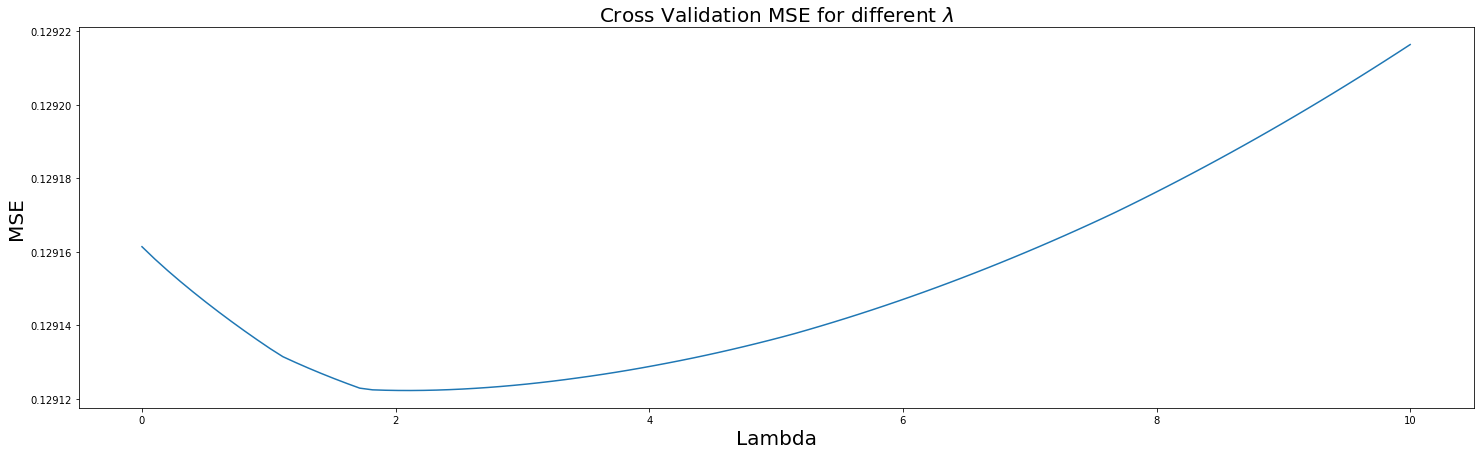

In [26]:
# Create folds
folds = np.array_split(np.arange(np.shape(X_chemistry_samples_std)[0]), 5)

# Set a range for lambda
lambd_range= np.linspace(0, 10, 100)

# Compute MSEs for these lambdas
mse_list = [cross_validation_lasso(X_chemistry_samples_std,
                                   y_chemistry_samples_std,
                                   lambd, folds) for lambd in lambd_range]

# Plot
plt.figure(figsize=(25,7))
plt.plot(lambd_range, mse_list)
plt.xlabel("Lambda", size=20)
plt.ylabel("MSE", size=20)
plt.title("Cross Validation MSE for different $\lambda$", size=20)
plt.show()

Now we find the optimal value of the hyper-parameter using our choose_best_lambd_lasso function. For a more precise value, increase the number of points in lambd_range.

In [27]:
# Compute the optimal lambda and the minimal MSE
min_MSE_lasso, optimal_lambda_lasso = choose_best_lambd_lasso(X_chemistry_samples_std,
                                                              y_chemistry_samples_std,
                                                              lambd_range=lambd_range,
                                                              folds=folds)
print("Minimal MSE from lasso regression= ", min_MSE_lasso)
print("Optimal lambda for lasso regression = ", optimal_lambda_lasso)

Minimal MSE from lasso regression=  0.12912221107858646
Optimal lambda for lasso regression =  2.121212121212121


We now fix the optimal value of the hyper-parameter and retrain the model on the entire samples dataset. We compute the in-sample $R^2$ and then compare it to the out-of-sample $R^2$ on the test data.

In [28]:
# Compute the betas for the ridge regression on entire sample dataset
betas_lasso = ridge_regression(X_chemistry_samples_std,
                               y_chemistry_samples_std,
                               optimal_lambda_lasso)

# Compute the two R^2
in_sample_R_squared_lasso = r_squared(X_chemistry_samples_std,
                                      y_chemistry_samples_std,
                                      betas_lasso)
                                      
out_sample_R_squared_lasso = r_squared(X_chemistry_test_std,
                                       y_chemistry_test_std,
                                       betas_lasso)

# Print results
print("In-sample R^2 =", in_sample_R_squared_lasso)
print("Out-of-sample R^2 =", out_sample_R_squared_lasso)

In-sample R^2 = 0.8718254802729744
Out-of-sample R^2 = 0.864297555323533


In [29]:
# Compute predictions
y_prediction_lasso = X_chemistry_test_std @ betas_lasso

# Compute the MSE
lasso_mse = np.mean((y_prediction_lasso - y_chemistry_test_std)**2)
print("The MSE of our lasso regression estimates is:  ", lasso_mse)

The MSE of our lasso regression estimates is:   0.12876394185401427


Now we compare the three regressions according to the following factors: Coefficients, In-sample and Out-of-sample $R^2$ and MSE of the predictions on the chemistry_test data.

First we print the beta coefficients for each of the three models.

In [30]:
coefficients = {"Linear regression": [beta for beta in betas_linear],
                "Ridge regression": [beta for beta in betas_ridge],
                "Lasso regression": [beta for beta in betas_lasso]}
pd.DataFrame(coefficients)

,Linear regression,Ridge regression,Lasso regression
0,7.453033e-16,7.462681e-16,7.458146e-16
1,2.901082e-02,3.090492e-02,3.001459e-02
2,4.456062e-01,4.434206e-01,4.444538e-01
3,-1.250212e-02,-1.398545e-02,-1.328523e-02
4,2.098112e-01,2.094865e-01,2.096403e-01
5,3.636985e-03,4.193321e-03,3.930515e-03
6,4.685249e-01,4.679405e-01,4.682176e-01
7,-2.188788e-01,-2.176614e-01,-2.182357e-01
8,-2.104391e-01,-2.086474e-01,-2.094892e-01
9,-6.627312e-02,-6.588858e-02,-6.607007e-02


Next we compare the MSEs and $R^2$ s for the three regressions.

In [31]:
table = {"Regression": ["Linear", "Ridge", "Lasso"],
         "MSE": [linear_mse, ridge_mse, lasso_mse],
         "In-sample R^2": [in_sample_R_squared_linear, in_sample_R_squared_ridge, in_sample_R_squared_lasso],
         "Out-of-sample R^2": [out_sample_R_squared_linear, out_sample_R_squared_ridge, out_sample_R_squared_lasso]}
pd.DataFrame(table)

,Regression,MSE,In-sample R^2,Out-of-sample R^2
0,Linear,0.128768,0.871826,0.864293
1,Ridge,0.128761,0.871824,0.864300
2,Lasso,0.128764,0.871825,0.864298


Overall, the three models are performing very similarly. We will now discuss the differences.

In terms of the MSE, the Ridge regression has the best outcome, followed by the Lasso regression and finally the Linear regression has the lowest (although very close to the other two) MSE.

While the in-sample $R^2$ is the largest for the Linear regression, it has the lowest out-of-sample $R^2$ which indicates that there is a slight overfitting there. Conversely, the Ridge regression has the lowest in-sample $R^2$ and the largest out-of-sample $R^2$ indicating that the model generalized the best. The Lasso regression has very close parameters to the Ridge, although it performes slightly worse.

In conclusion, the Ridge regression seems to perform the best out of the three models in terms of both MSE and out-of-sample $R^2$.